## Importing Libraries

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense 
print('TensorFlow',tf.__version__)

TensorFlow 2.1.0


## Connecting the Colab Notebook to Google Drive to access the Data and Save Checkpoints

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Checking RAM and GPU Capacities

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.2 GB  | Proc size: 375.4 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


# **Training**

## Loading the Dataset using tensorflow_datasets 

In [0]:
NUM_SAMPLES = 3200000
dataset = tfds.load(name='wmt14_translate/fr-en', as_supervised=True, download=False, data_dir="/content/drive/My Drive")
dataset['train'] = dataset['train'].take(NUM_SAMPLES)

## Adding Start and End Sequence Markers

In [5]:
en_sentences = []
fr_sentences = []
for example in tqdm(dataset['train']):
    en_sentences.append(example[0].numpy().decode())
    fr_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')
for example in tqdm(dataset['validation']):
    en_sentences.append(example[0].numpy().decode())
    fr_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')    

3200000it [19:11, 2779.67it/s]
3000it [00:01, 2800.17it/s]


## Tokenization

In [0]:
en_tk = Tokenizer(num_words=30000)
fr_tk = Tokenizer(num_words=30000)
   
en_tk.fit_on_texts(en_sentences)
fr_tk.fit_on_texts(fr_sentences)    

## Visualizing Sequence Lengths

English sentences : mean = 28.57567624102404, std = 26.186013960097267, max = 9139
French sentences : mean = 26.956515766468936, std = 22.07819301437233, max = 8466


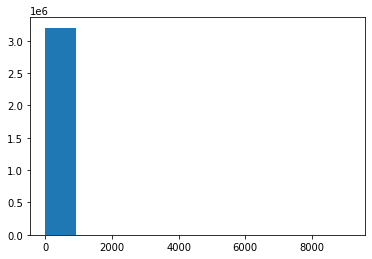

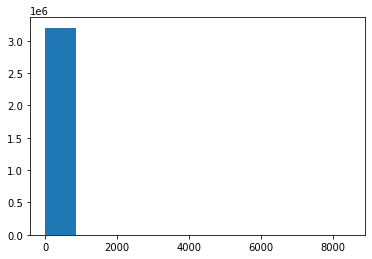

In [7]:
en_lens = [len(x.split()) for x in en_sentences]
fr_lens = [len(x.split()) for x in fr_sentences]

plt.figure()
plt.hist(en_lens)

plt.figure()
plt.hist(fr_lens)

en_mean = np.mean(en_lens)
en_std = np.std(en_lens)
fr_mean = np.mean(fr_lens)
fr_std = np.std(fr_lens)
en_max = np.max(en_lens)
fr_max = np.max(fr_lens)

print(f'English sentences : mean = {en_mean}, std = {en_std}, max = {en_max}')
print(f'French sentences : mean = {fr_mean}, std = {fr_std}, max = {fr_max}')

In [0]:
max_sequence_len = 30
en_vocab_size = 30000
fr_vocab_size = 30000

## Tokenization and Sequence Padding

In [0]:
def preprocess_en(en):
    encoded_en = en_tk.texts_to_sequences(en)
    padded_en = pad_sequences(encoded_en, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_en

def preprocess_fr(fr):
    encoded_fr = fr_tk.texts_to_sequences(fr)
    padded_fr = pad_sequences(encoded_fr, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_fr

def preprocess_text(en, fr):
    return preprocess_en(en.numpy().decode()), preprocess_fr(fr.numpy().decode())

## Preparing Training Dataset

In [0]:
train_ds = dataset['train']
train_en = []
train_fr = []
for example in tqdm(train_ds):
    train_en.append(example[0].numpy().decode())
    train_fr.append('startseq ' + example[1].numpy().decode() + ' endseq')
train_en = preprocess_en(train_en)
train_fr = preprocess_fr(train_fr)

batch_size = 80
train_dataset = tf.data.Dataset.from_tensor_slices((train_en, train_fr))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Defining Encoder, Decoder, and Attention Models using tf.keras *Model Subclassing*

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_size=1000, max_sequence_len=30, batch_size=batch_size, embedding_dim=620, vocab_size=30000):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU_1 = Bidirectional(GRU(units=hidden_size, return_sequences=True, return_state=True, kernel_initializer=self.initializer,
                                       bias_initializer='zeros'))

    def initial_hidden_state(self):
        return [tf.zeros(shape=(self.batch_size, self.hidden_size),) for i in range(2)]

    def call(self, x, initial_state, training=False):
        x = self.embedding_layer(x)
        x, hidden_state,_ = self.GRU_1(x, initial_state=initial_state)
        return x, hidden_state


class Attention(tf.keras.Model):
    def __init__(self, hidden_size=256):
        super(Attention, self).__init__()
        self.initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)
        self.fc1 = Dense(units=hidden_size, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')
        self.fc2 = Dense(units=hidden_size, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')
        self.fc3 = Dense(units=1, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')

    def call(self, encoder_output, hidden_state, training=False):
        '''hidden_state : h(t-1)'''
        y_hidden_state = tf.expand_dims(hidden_state, axis=1)
        y_hidden_state = self.fc1(y_hidden_state)
        y_enc_out = self.fc2(encoder_output)

        y = tf.keras.backend.tanh(y_enc_out + y_hidden_state)
        attention_score = self.fc3(y)
        attention_weights = tf.keras.backend.softmax(attention_score, axis=1)

        context_vector = tf.multiply(encoder_output, attention_weights)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, hidden_size=1000, max_sequence_len=30, batch_size=batch_size, embedding_dim=620, vocab_size=30000):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU = GRU(units=hidden_size,
                       return_sequences=True, return_state=True)
        self.attention = Attention(hidden_size=self.hidden_size)
        self.fc = Dense(units=self.vocab_size, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')

    def initial_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.hidden_size))

    def call(self, x, encoder_output, hidden_state, training=False):
        x = self.embedding_layer(x)
        context_vector, attention_weights = self.attention(
            encoder_output, hidden_state, training=training)
        contect_vector = tf.expand_dims(context_vector, axis=1)
        x = tf.concat([x, contect_vector], axis=-1)
        x, curr_hidden_state = self.GRU(x)
        x = tf.reshape(x, shape=[self.batch_size, -1])
        x = self.fc(x)
        return x, curr_hidden_state, attention_weights

## Defining Training Loop, Loss Function, and Optimizer

In [0]:
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adadelta(rho=0.95, epsilon=1e-06)
train_accuracy = tf.metrics.SparseCategoricalAccuracy()


def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    mask = 1 - tf.cast(tf.equal(y_true, 0), 'float32')
    return tf.reduce_mean(loss * mask)
    
@tf.function()
def training_step(en, fr):    
    with tf.GradientTape() as Tape:
        encoder_init_state = encoder.initial_hidden_state()
        encoder_output, encoder_hidden_state = encoder(en, encoder_init_state, training=True)
        decoder_hidden = encoder_hidden_state
        loss = 0
        acc = []
        current_word = tf.expand_dims(fr[:, 0], axis=1)
        for word_idx in range(1, max_sequence_len):
            next_word = fr[:, word_idx]
            logits, decoder_hidden, attention_weights = decoder(current_word, encoder_output, decoder_hidden, training=True)
            loss += loss_function(next_word, logits)
            acc.append(train_accuracy(next_word, logits))
            current_word = tf.expand_dims(next_word, axis=1)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = Tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss, tf.reduce_mean(acc)

## Initializing Encoder, Decoder, and the Checkpoint Directory

In [0]:
encoder = Encoder()
decoder = Decoder()
checkpoint_dir = '/content/drive/My Drive/training3200000'
checkpoint_prefix = '/content/drive/My Drive/training3200000/ckpt'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

## Restoring the Checkpoint to Continue Training

In [14]:
checkpoint.restore('/content/drive/My Drive/training3200000/ckpt-9')

## Training the Model

In [0]:
epochs = 10
num_steps = NUM_SAMPLES // batch_size
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    ep_loss = []
    ep_acc = []
    progbar = tf.keras.utils.Progbar(target=num_steps, stateful_metrics=[
                                     'curr_loss', 'curr_accuracy'], unit_name='batch')

    for step, example in enumerate(train_dataset):
        en = example[0]
        fr = example[1]
        loss, acc = training_step(en, fr)
        loss /= fr.shape[1]
        ep_loss.append(loss)
        ep_acc.append(acc)
        progbar.update(
            step + 1, values=[('curr_loss', loss), ('curr_accuracy', acc)])

    checkpoint.save(file_prefix=checkpoint_prefix)
    print(checkpoint_prefix)
    print(f'Metrics after epoch {epoch} : Loss => {np.mean(ep_loss):.3f} | Accuracy => {np.mean(ep_acc):.3f}')
checkpoint.save(file_prefix=checkpoint_prefix)

## Checking Time Left on Google Colab (limit is 12 hours = 43,200 seconds)

In [16]:
import time, psutil
uptime = time.time() - psutil.boot_time()
remain = 12*60*60 - uptime
print(remain)

39193.249314546585


# **Inference**

## Restoring the Checkpoint to perform Inference

In [17]:
checkpoint.restore('/content/drive/My Drive/training3200000/ckpt-10')

## Inference function

In [0]:
def translate_sentence(sentence):
    sentence = preprocess_en([sentence])
    enc_init = tf.zeros(shape=[1, 1024])
    enc_out, enc_hidden = encoder(sentence, enc_init)

    decoder.batch_size = 1
    fr_tk.index_word[0] = ''
    decoded = []
    att = []
    current_word = tf.expand_dims([fr_tk.word_index['startseq']], axis=0) 
    decoder_hidden = enc_hidden
    for word_idx in range(1, max_sequence_len):
        logits, decoder_hidden, attention_weights = decoder(current_word, enc_out, decoder_hidden)
        decoded_idx = np.argmax(logits)
        if fr_tk.index_word[decoded_idx] == 'endseq':
            break
        decoded.append(fr_tk.index_word[decoded_idx])
        att.append(attention_weights.numpy().squeeze())
        current_word = tf.expand_dims([decoded_idx], axis=0)
    return ' '.join(decoded), att

## Translating and Visualizing Attention Heatmaps

In [0]:
ref_en_sentences = ["there is a misunderstanding",
                    "what do you want",
                    "are you crazy",
                    "state of the art",
                    "the exam is difficult",
                    "do you want to play with me",
                    "how are you",
                    "i must tell you that I am very dangerous",
                    "do you have any idea how to use it",
                    "can I have some coffee",
                    "the sun is bright today",
                    "once the precautions have been taken we can begin initiation",
                    "the shoes are white with black concentric circles on them",
                    "i found a treasure map on the way home today",
                    "i went to the supermarket the other day and they let me pick a surprise from the community prize barrel",
                    "once upon a time there was a brightly young damsel nicknamed Little Red Riding Hood who was happily skipping through the forest on her way to her grandmothers country house",
                    "with little to no idea as to what to do next Michael decided that the only sensible course of action was to let go of the past and move on",
                    "the village consisted of the sheriffs office along with the cowboy bar and thirty desolate residents who had only these two institutions to visit in times of duress and emptiness",
                    ]

In [0]:
fre_sentences = ["il y a un malentendu",
                 'que veux tu',
                 'es tu fou',
                 "l'état de l'art",
                 "l'examen est difficile", 
                 'voulez vous jouer avec moi',
                 "comment allez vous",
                 'je dois vous dire que je suis très dangereux',
                 "as tu une idée de comment l'utiliser",
                 "Puis-je avoir du café",
                 "Le soleil est brillant aujourd'hui",
                 "Une fois les précautions prises, nous pouvons commencer l'initiation",
                 "Les chaussures sont blanches avec des cercles concentriques noirs sur eux",
                 "J'ai trouvé une carte au trésor sur le chemin du retour aujourd'hui",
                 "Je suis allé au supermarché l'autre jour et ils m'ont laissé choisir une surprise dans le baril de prix communautaire",
                 "Il était une fois une jeune fille enjouée surnommée le petit chaperon rouge qui sautait joyeusement à travers la forêt en se rendant à la maison de campagne de sa grand-mère",
                 "Avec peu ou aucune idée de ce qu'il fallait faire ensuite, Michael a décidé que la seule solution raisonnable était de laisser aller le passé et de passer à autre chose",
                 "Le village se composait du bureau des shérifs ainsi que du cowboy bar et d'une trentaine d'habitants désolés qui n'avaient que ces deux institutions à visiter en période de contrainte et de vide",
                 ]

hyp_en_sentences = []

FR :  il y a un malentendu
EN :  there is a misunderstanding
OR :  there is a misunderstanding
---------------------------------------------------------------------------
FR :  que veux tu
EN :  what do you want
OR :  what do you want
---------------------------------------------------------------------------
FR :  es tu fou
EN :  you are
OR :  are you crazy
---------------------------------------------------------------------------
FR :  l'état de l'art
EN :  the state of art
OR :  state of the art
---------------------------------------------------------------------------
FR :  l'examen est difficile
EN :  the review is difficult
OR :  the exam is difficult
---------------------------------------------------------------------------
FR :  voulez vous jouer avec moi
EN :  do you want to play with me
OR :  do you want to play with me
---------------------------------------------------------------------------
FR :  comment allez vous
EN :  how do you go
OR :  how are you
----------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


FR :  Une fois les précautions prises, nous pouvons commencer l'initiation
EN :  once the precautions taken we can start the initiation of the initiation of the initiation of the initiation of the initiation of the initiation of the initiation of the
OR :  once the precautions have been taken we can begin initiation
---------------------------------------------------------------------------
FR :  Les chaussures sont blanches avec des cercles concentriques noirs sur eux
EN :  the footwear is white with black circles
OR :  the shoes are white with black concentric circles on them
---------------------------------------------------------------------------
FR :  J'ai trouvé une carte au trésor sur le chemin du retour aujourd'hui
EN :  i found a map to the bank on the return to today
OR :  i found a treasure map on the way home today
---------------------------------------------------------------------------
FR :  Je suis allé au supermarché l'autre jour et ils m'ont laissé choisir une surp

<Figure size 360x288 with 0 Axes>

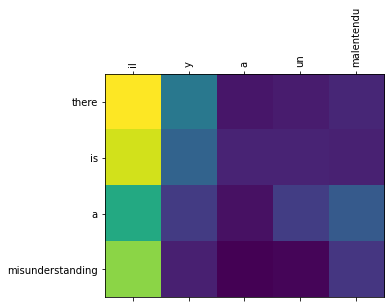

<Figure size 216x288 with 0 Axes>

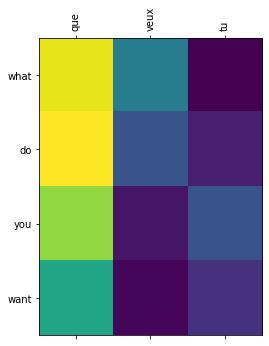

<Figure size 216x144 with 0 Axes>

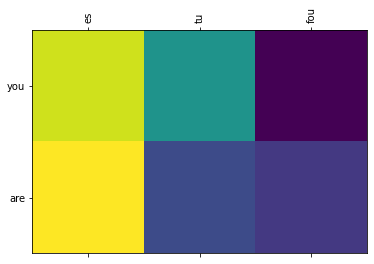

<Figure size 216x288 with 0 Axes>

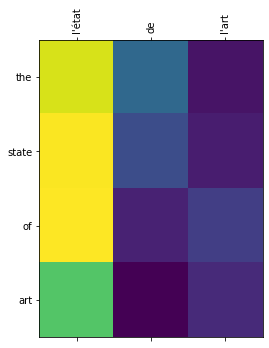

<Figure size 216x288 with 0 Axes>

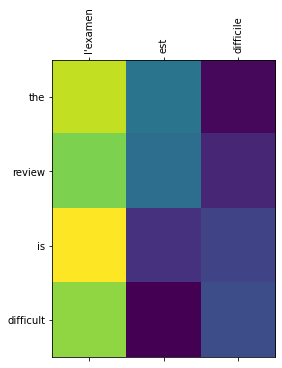

<Figure size 360x504 with 0 Axes>

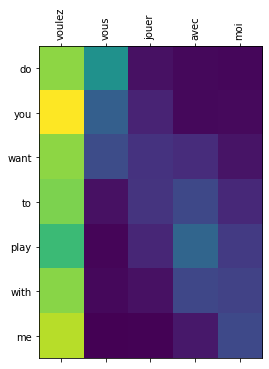

<Figure size 216x288 with 0 Axes>

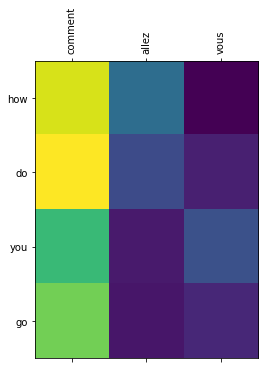

<Figure size 648x648 with 0 Axes>

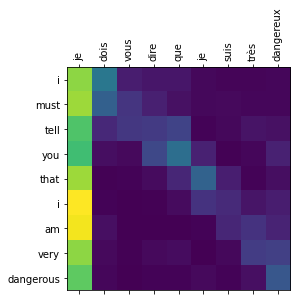

<Figure size 504x720 with 0 Axes>

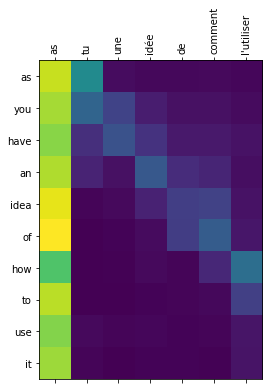

<Figure size 288x288 with 0 Axes>

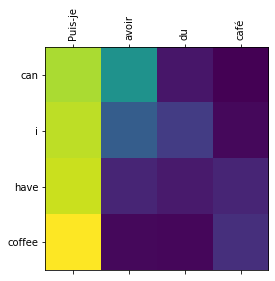

<Figure size 360x360 with 0 Axes>

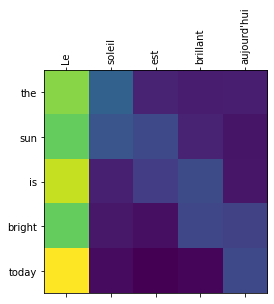

<Figure size 648x2088 with 0 Axes>

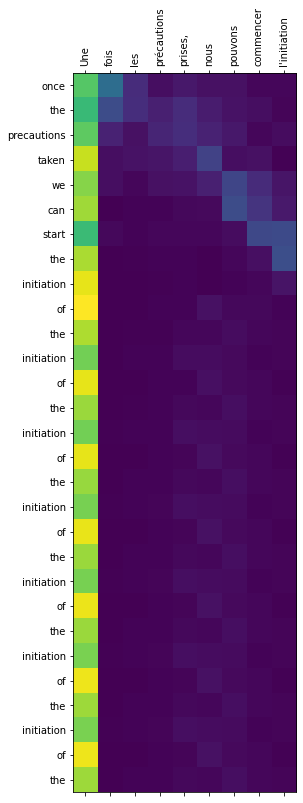

<Figure size 792x504 with 0 Axes>

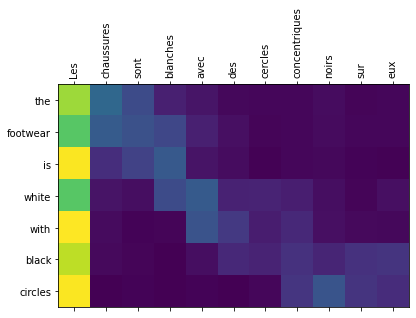

<Figure size 864x864 with 0 Axes>

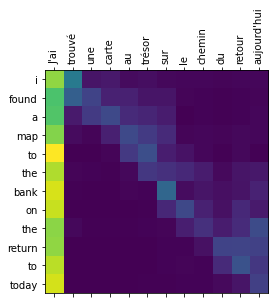

<Figure size 1440x1296 with 0 Axes>

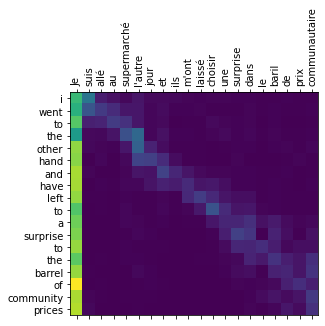

<Figure size 2232x1368 with 0 Axes>

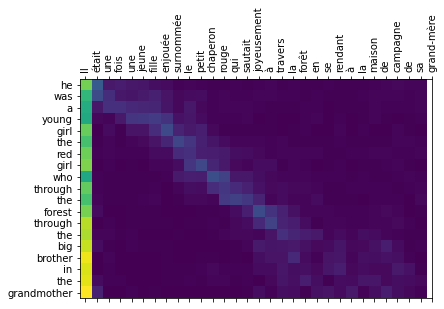

<Figure size 2232x2088 with 0 Axes>

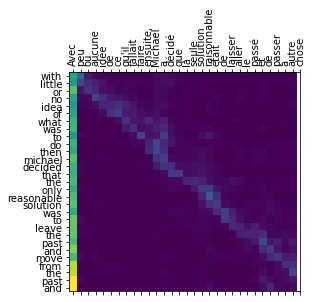

<Figure size 2376x2088 with 0 Axes>

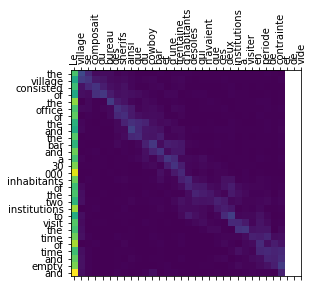

In [21]:
for inp_sentence, original in zip(fre_sentences, ref_en_sentences):
    inp_array = inp_sentence.split()
    inp_len = len(inp_sentence.split())
    trans_sentence, attention_weights = translate_sentence(inp_sentence)
    trans_array = trans_sentence.split()
    trans_len = len(trans_array)
    attention_weights = np.array([x for x in attention_weights])
    attention_weights = attention_weights[:trans_len,:inp_len]
    plt.figure(figsize=(inp_len, trans_len))
    plt.matshow(attention_weights)
    plt.xticks(ticks=range(inp_len), labels=inp_array, rotation=90)
    plt.yticks(ticks=range(trans_len), labels=trans_array)
    print('FR : ', inp_sentence)
    print('EN : ', trans_sentence)
    print('OR : ', original)
    print('-'*75)